In [1]:
import os
import re
import librosa
import subprocess
import numpy as np
from random import choices
from splitfolders import ratio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [2]:
my_seed = 1337

# Functions

In [3]:
def process_audio(file, path):
    audio_data, sampling_rate = librosa.load(os.path.join(path, file)) 
    time = np.arange(0, len(audio_data)) / sampling_rate  
    return audio_data, sampling_rate, time

In [4]:
def wave_to_spec(file, path):
    audio_data, sampling_rate, time = process_audio(file, path)
    S = librosa.feature.melspectrogram(y=audio_data, sr=sampling_rate)
    spectrogram_db = librosa.power_to_db(S, ref=np.max)
    return spectrogram_db, S

In [5]:
def get_spec_from_wav(files, path):
    for file in files:
        spectrogram, S = wave_to_spec(file, path)
        yield spectrogram

In [6]:
def extract_label(file_name, class_names, output_labels):
    for i, class_name in enumerate(class_names):
        if class_name in file_name.split('_')[0]:
            return output_labels[i]

In [7]:
def create_model():
    model_layers = [
        tf.keras.layers.Input(input_shape),
        tf.keras.layers.Conv1D(filters=4, kernel_size=(1,), padding='causal', activation='relu', name="conv1d-1"),
        tf.keras.layers.MaxPool1D(pool_size=(1,), strides=(1,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(filters=8, kernel_size=(1,), padding='causal', activation='relu', name="conv1d-2"),
        tf.keras.layers.MaxPool1D(pool_size=(1,), strides=(1,)),
        tf.keras.layers.BatchNormalization(),
         
        tf.keras.layers.Flatten(),
         
        tf.keras.layers.Dense(units=8, activation='relu'),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=len(output_labels), activation='softmax')
    ]
    model = Sequential(model_layers)
    return model

In [8]:
def check_model_predictions(predictions, correct_output):
    max_len = max(len(str(pred)) for pred in predictions)-3
    for i, pred in enumerate(predictions):
        index = np.where(pred == max(pred))
        if index == correct_output[i]:
            print(f'{str(pred):<{max_len}} {correct_output[i]} True')
        else:
            print(f'{str(pred):<{max_len}} {correct_output[i]} False')

In [9]:
# name the weights file
def model_weights_naming(n: str = "0"):
    assert n.isdigit(), "n must be an integer string or 'null'"
    return f"model{n}.weights.h5"

In [10]:
def get_next_weights_filename(weights_dir):
    pattern = re.compile(r"model(\d+)\.weights\.h5")
    max_n = -1
    for fname in os.listdir(weights_dir):
        match = pattern.match(fname)
        if match:
            num = int(match.group(1))
            max_n = max(max_n, num)
    next_n = str(max_n + 1)
    return os.path.join(weights_dir, model_weights_naming(next_n))

In [11]:
def select_file_from_dir(directory, number: str):
    for filename in os.listdir(directory):
        # check if it's a file (not a directory)
        pattern = re.compile(rf'model{re.escape(number)}\.weights\.h5')
    
        for filename in os.listdir(directory):
            if os.path.isfile(os.path.join(directory, filename)):
                if pattern.match(filename):
                    return filename
    raise FileNotFoundError(f"No file containing the number '{number}' found in directory '{directory}'")

# A. Define the dataset and split it into train and test

In [12]:
original_ds_path = "dataset/dataset/"

In [13]:
ds_path = "ds_split/"
subprocess.run(["rm", "-rf", ds_path]) 
ratio(original_ds_path, seed=my_seed, output=ds_path, ratio=(0.8, 0, 0.2))
subprocess.run(["rm", "-rf", os.path.join(ds_path, "val")]) 

Copying files: 440 files [00:00, 2559.18 files/s]


CompletedProcess(args=['rm', '-rf', 'ds_split/val'], returncode=0)

In [14]:
train_path = os.path.join(ds_path, "train/dataset")
test_path = os.path.join(ds_path, "test/dataset")

# B. Process train and test datasets

### Values for plotting

In [15]:
fontsize = 32
n = 9
rows = cols = int(n / 2) if isinstance(n / 2, int) else int(n / 3)
rand_samples = choices(os.listdir(train_path), k=n)
rand_samples

['I_BLE01_EU_FN_DEL01_209.wav',
 'I_DAK01_MC_FN_SIM01_312.wav',
 'I_CLE01_EU_FN_FER01_114.wav',
 'I_ANI01_MC_FN_SIM01_101.wav',
 'B_WHO01_MC_FI_SIM01_201.wav',
 'I_DAK01_MC_FN_SIM01_312.wav',
 'F_LEO01_EU_MI_RIT01_101.wav',
 'I_NUL01_MC_MI_SIM01_303.wav',
 'I_BLE01_EU_FN_DEL01_110.wav']

### 1. Plot waveforms of first audio recordings

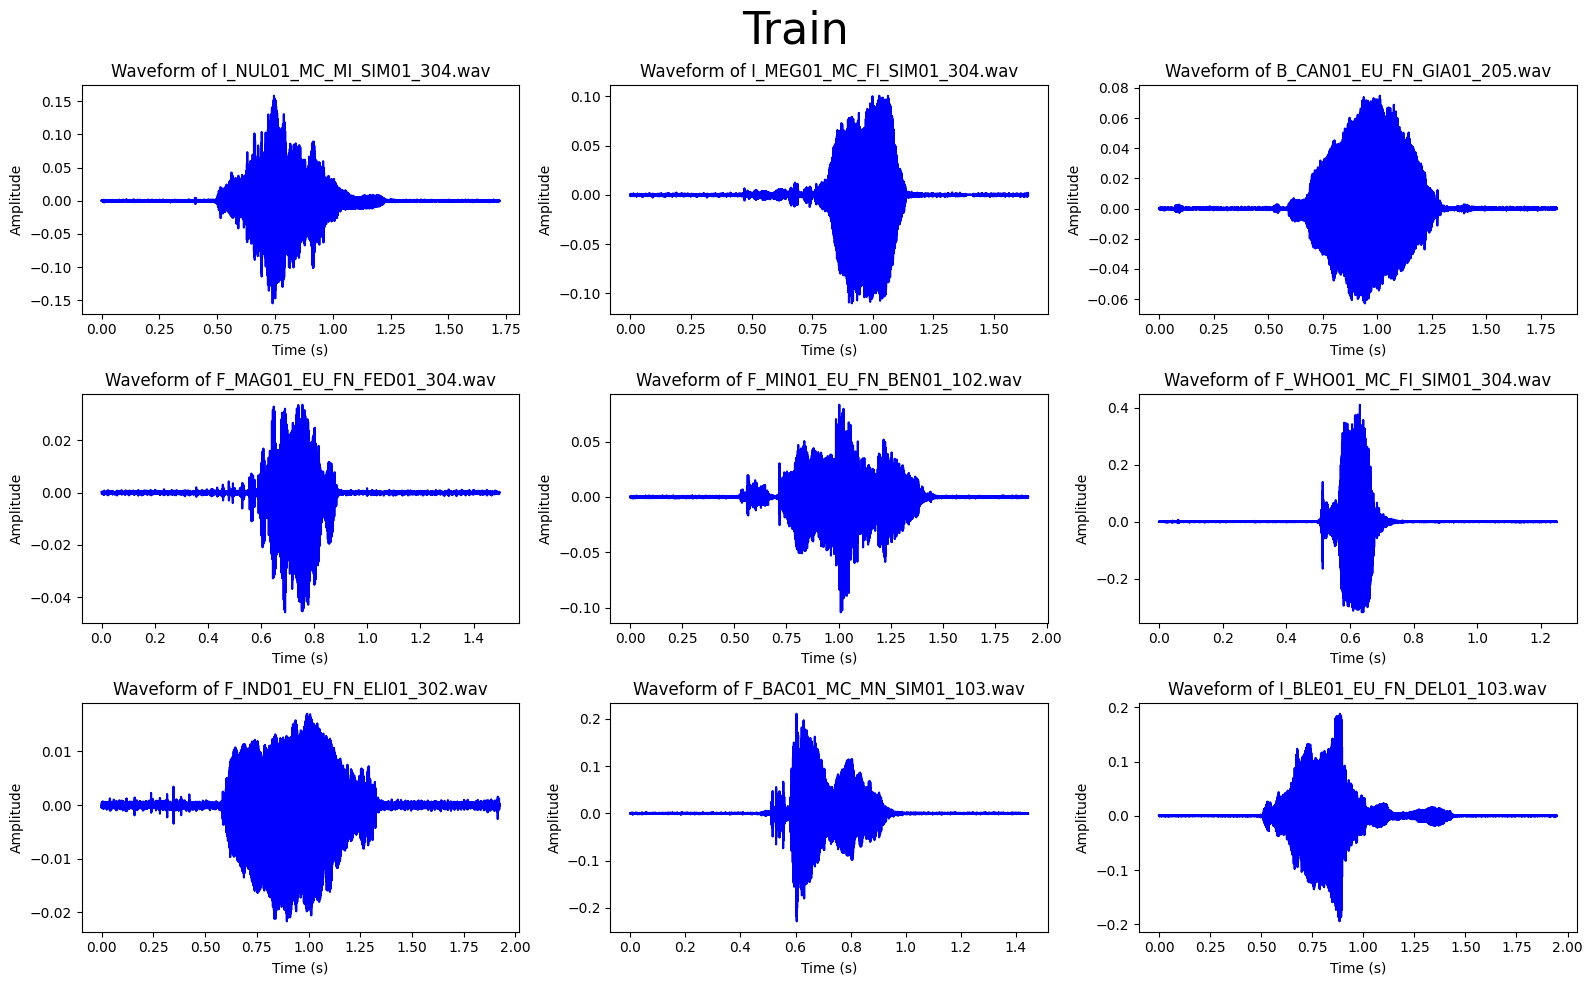

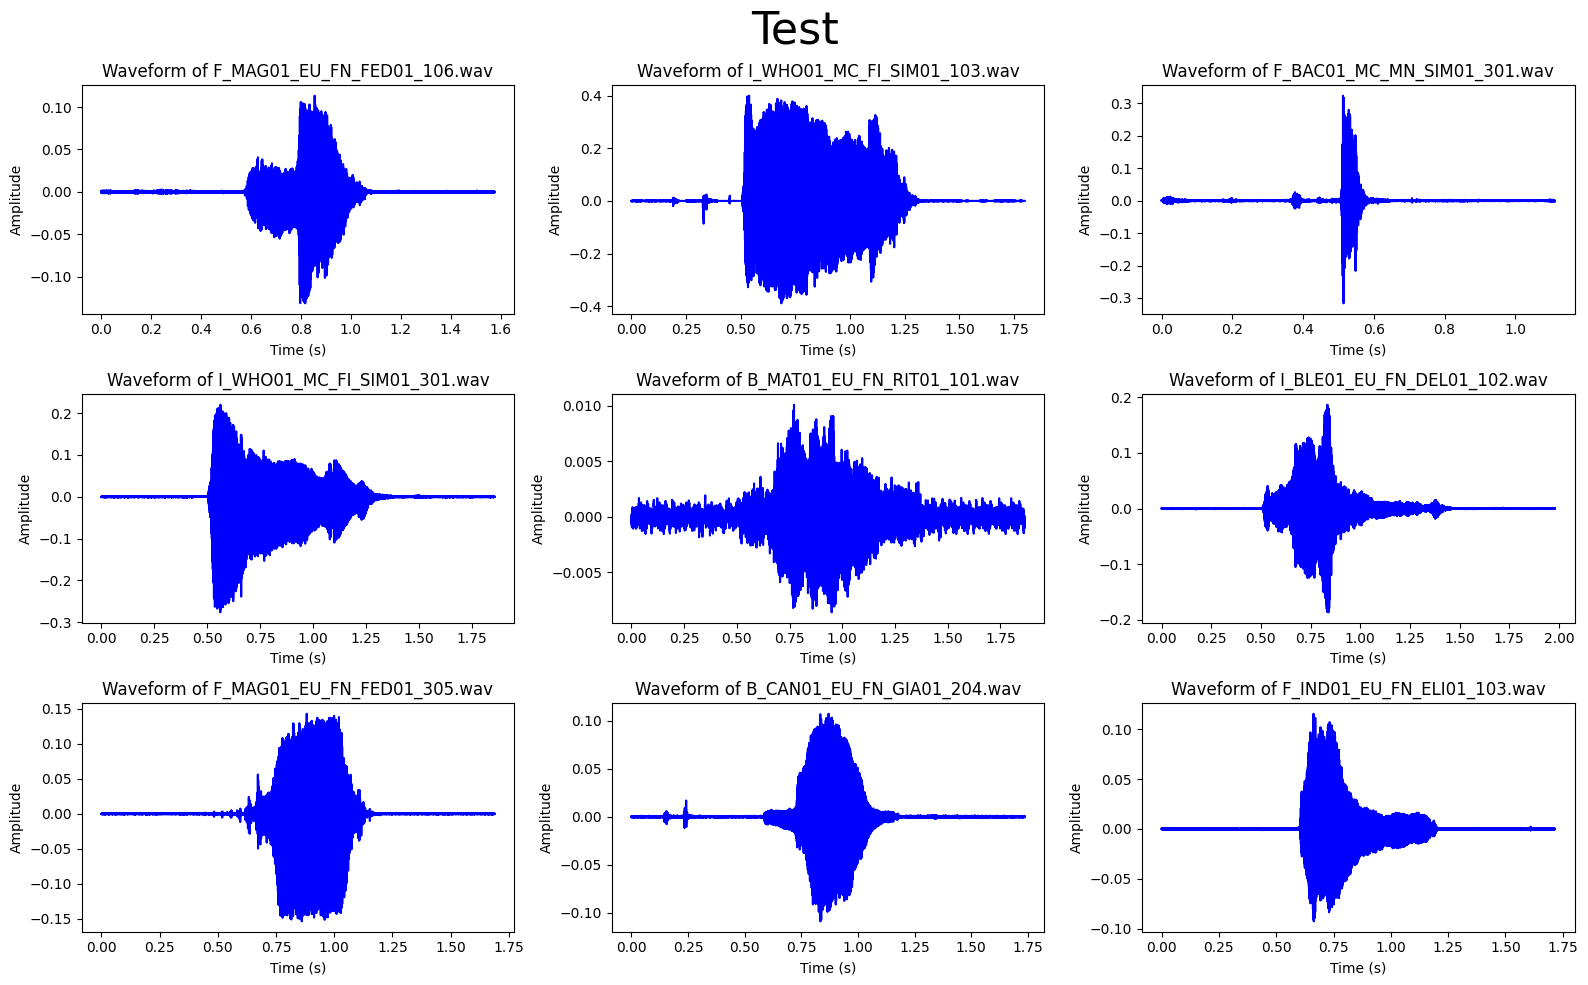

In [16]:
# train
plt.figure(figsize=(16, 10))
plt.suptitle("Train", fontsize=fontsize)
temp_train_files = os.listdir(train_path)[:n]
for i in range(n):
    audio_data, sampling_rate, time = process_audio(temp_train_files[i], train_path)
    plt.subplot(rows, cols, i+1)
    plt.plot(time, audio_data, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Waveform of {temp_train_files[i]}')

plt.tight_layout()
plt.show()

# test
plt.figure(figsize=(16, 10))
plt.suptitle("Test", fontsize=fontsize)
temp_test_files = os.listdir(test_path)[:n]
for i in range(n):
    audio_data, sampling_rate, time = process_audio(temp_test_files[i], test_path)
    plt.subplot(rows, cols, i+1)
    plt.plot(time, audio_data, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Waveform of {temp_test_files[i]}')

plt.tight_layout()
plt.show()

### 2. Convert waveforms to spectrograms

In [17]:
len(os.listdir(train_path)), len(os.listdir(test_path))

(352, 88)

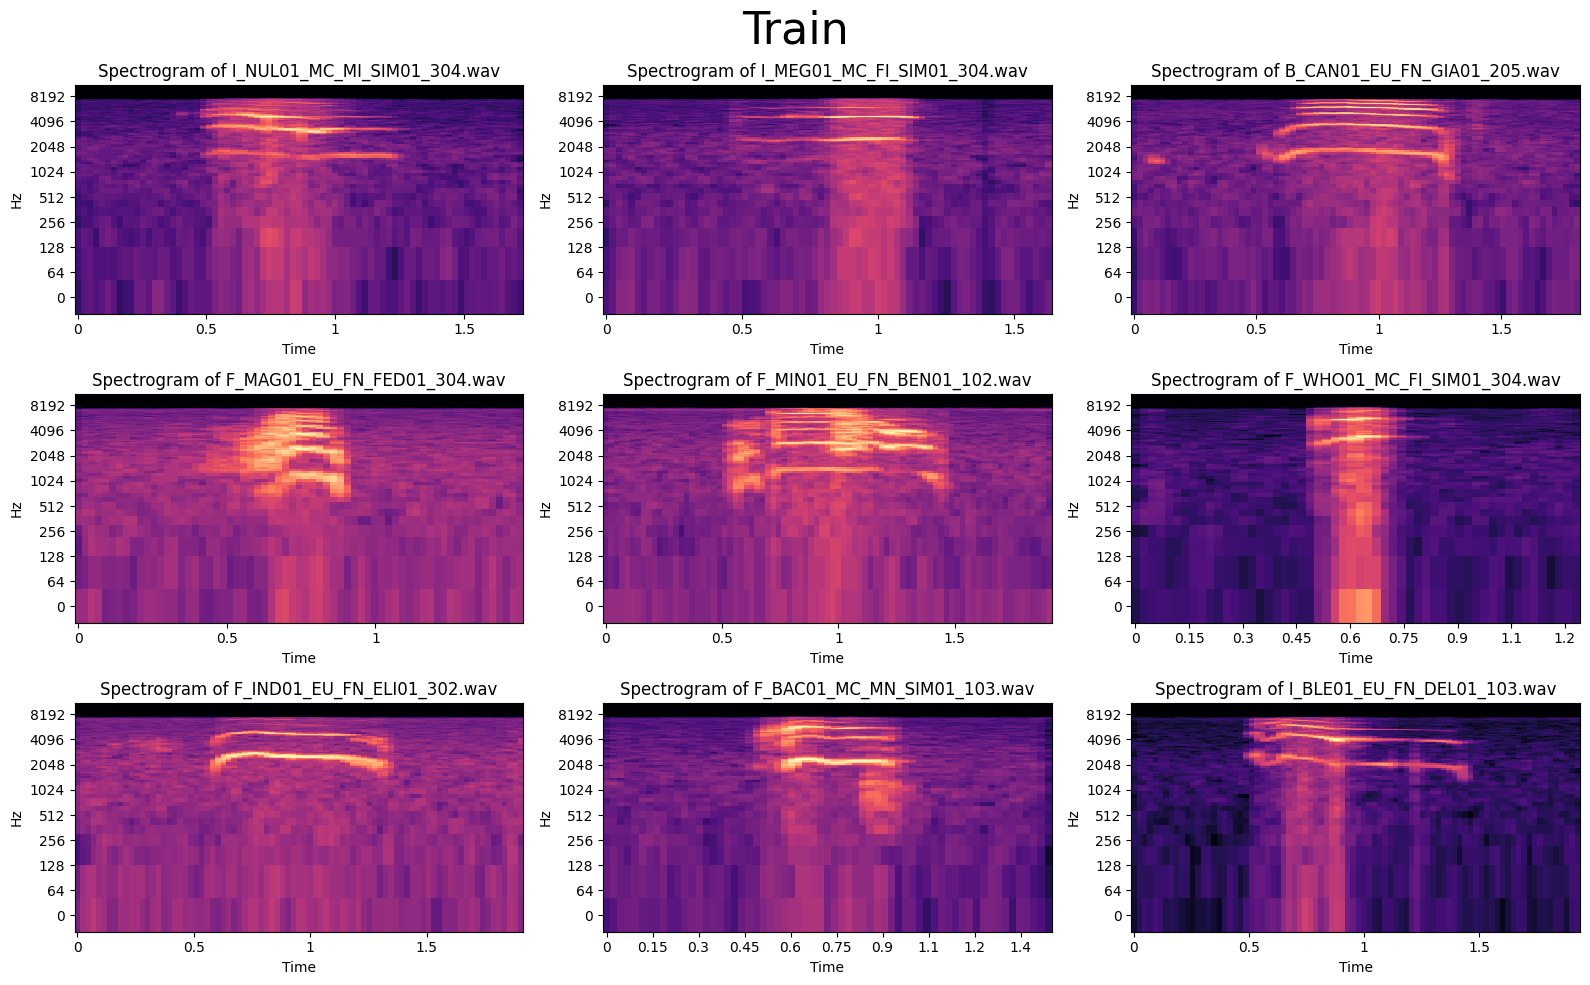

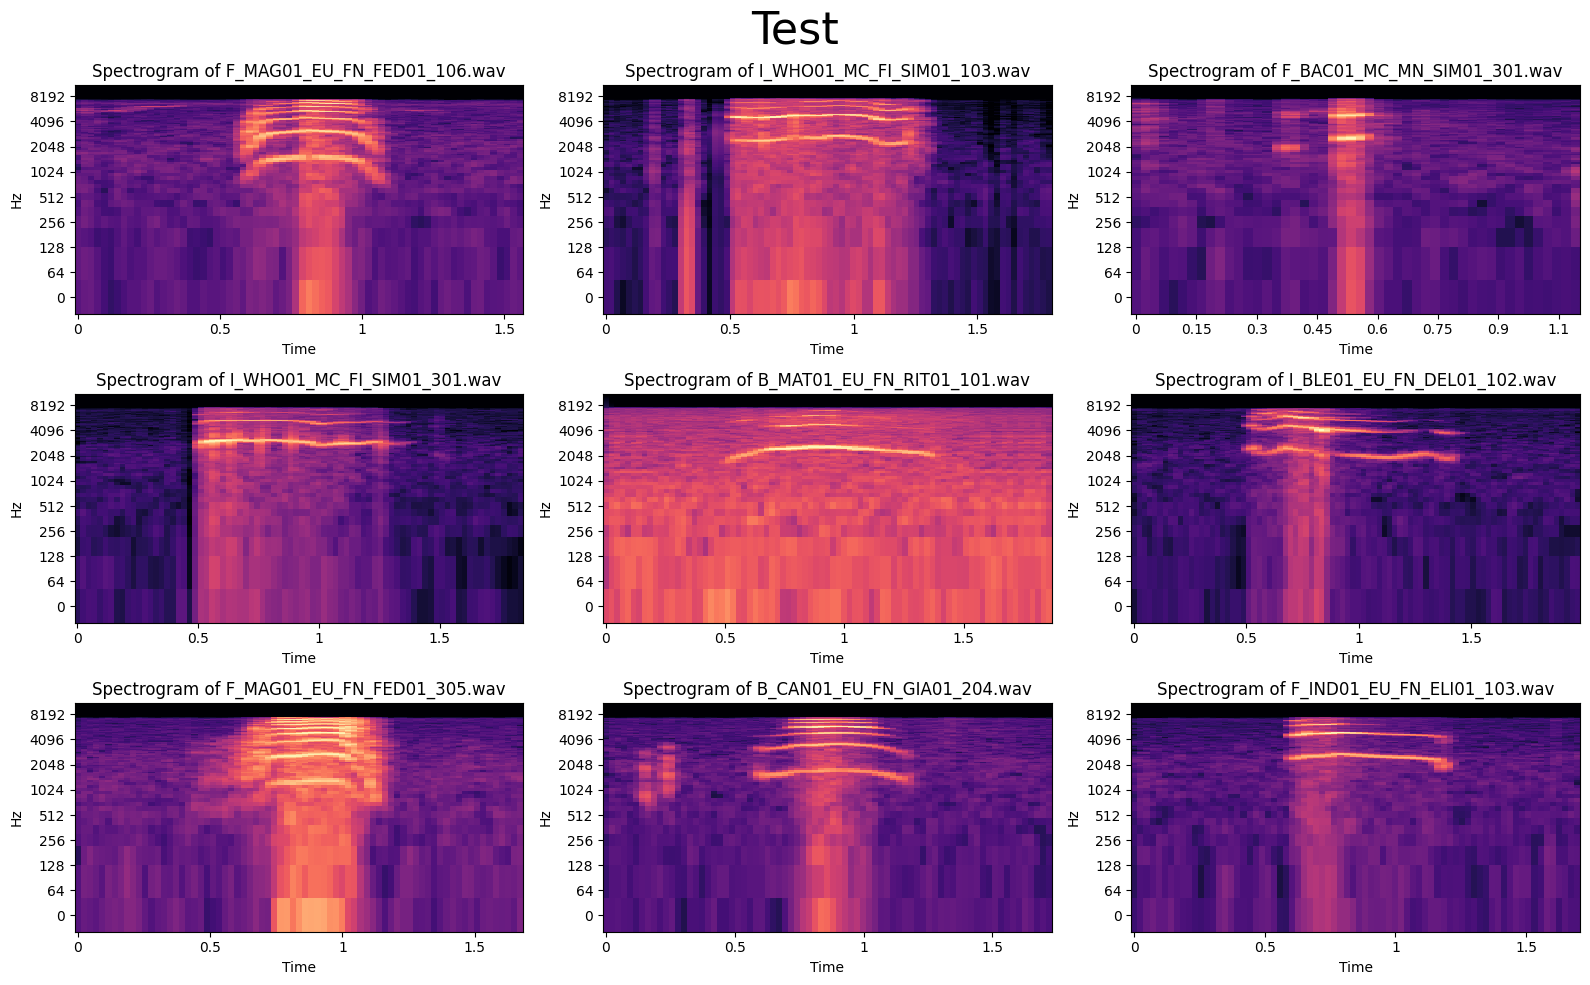

In [18]:
# train
train_specs_list = []
plt.figure(figsize=(16, 10))
plt.suptitle("Train", fontsize=fontsize)

for i, file in enumerate(os.listdir(train_path)):
    spectrogram_db, _ = wave_to_spec(file, train_path)
    train_specs_list.append(spectrogram_db)  # collect spectrograms in a list
    if i < n:
        plt.subplot(rows, cols, i+1)
        librosa.display.specshow(spectrogram_db, sr=sampling_rate, x_axis='time', y_axis='log') #y_axis='log'
        plt.title(f'Spectrogram of {file}')

plt.tight_layout()
plt.show()

# test
test_specs_list = []
plt.figure(figsize=(16, 10))
plt.suptitle("Test", fontsize=fontsize)

for i, file in enumerate(os.listdir(test_path)):
    spectrogram_db, _ = wave_to_spec(file, test_path)
    test_specs_list.append(spectrogram_db)  # collect spectrograms in a list
    if i < n:
        plt.subplot(rows, cols, i+1)
        librosa.display.specshow(spectrogram_db, sr=sampling_rate, x_axis='time', y_axis='log') #y_axis='log'
        plt.title(f'Spectrogram of {file}')

plt.tight_layout()
plt.show()

### 3. Reshape all spectrograms to match the longest time duration

In [19]:
max_len = 0
const_val = 0

for sublist_2d in train_specs_list + test_specs_list:
    max_len = max(max_len, sublist_2d.shape[1])

# train
for i, sublist_2d in enumerate(train_specs_list):
    if sublist_2d.shape[1] < max_len:
        pad_width = ((0, 0), (0, max_len - sublist_2d.shape[1]))
        padded_array = np.pad(sublist_2d, pad_width=pad_width, mode='constant', constant_values=const_val)
        train_specs_list[i] = padded_array

train_specs = np.array(train_specs_list)

# check if all lengths are the same
lengths_train = {len(sublist_1d) for sublist_2d in train_specs for sublist_1d in sublist_2d}
all_equal_train = len(lengths_train) == 1
print(lengths_train, all_equal_train)


# test
for i, sublist_2d in enumerate(test_specs_list):
    if sublist_2d.shape[1] < max_len:
        pad_width = ((0, 0), (0, max_len - sublist_2d.shape[1]))
        padded_array = np.pad(sublist_2d, pad_width=pad_width, mode='constant', constant_values=const_val)
        test_specs_list[i] = padded_array

test_specs = np.array(test_specs_list)

# check if all lengths are the same
lengths_test = {len(sublist_1d) for sublist_2d in test_specs for sublist_1d in sublist_2d}
all_equal_test = len(lengths_test) == 1
print(lengths_test, all_equal_test)

{173} True
{173} True


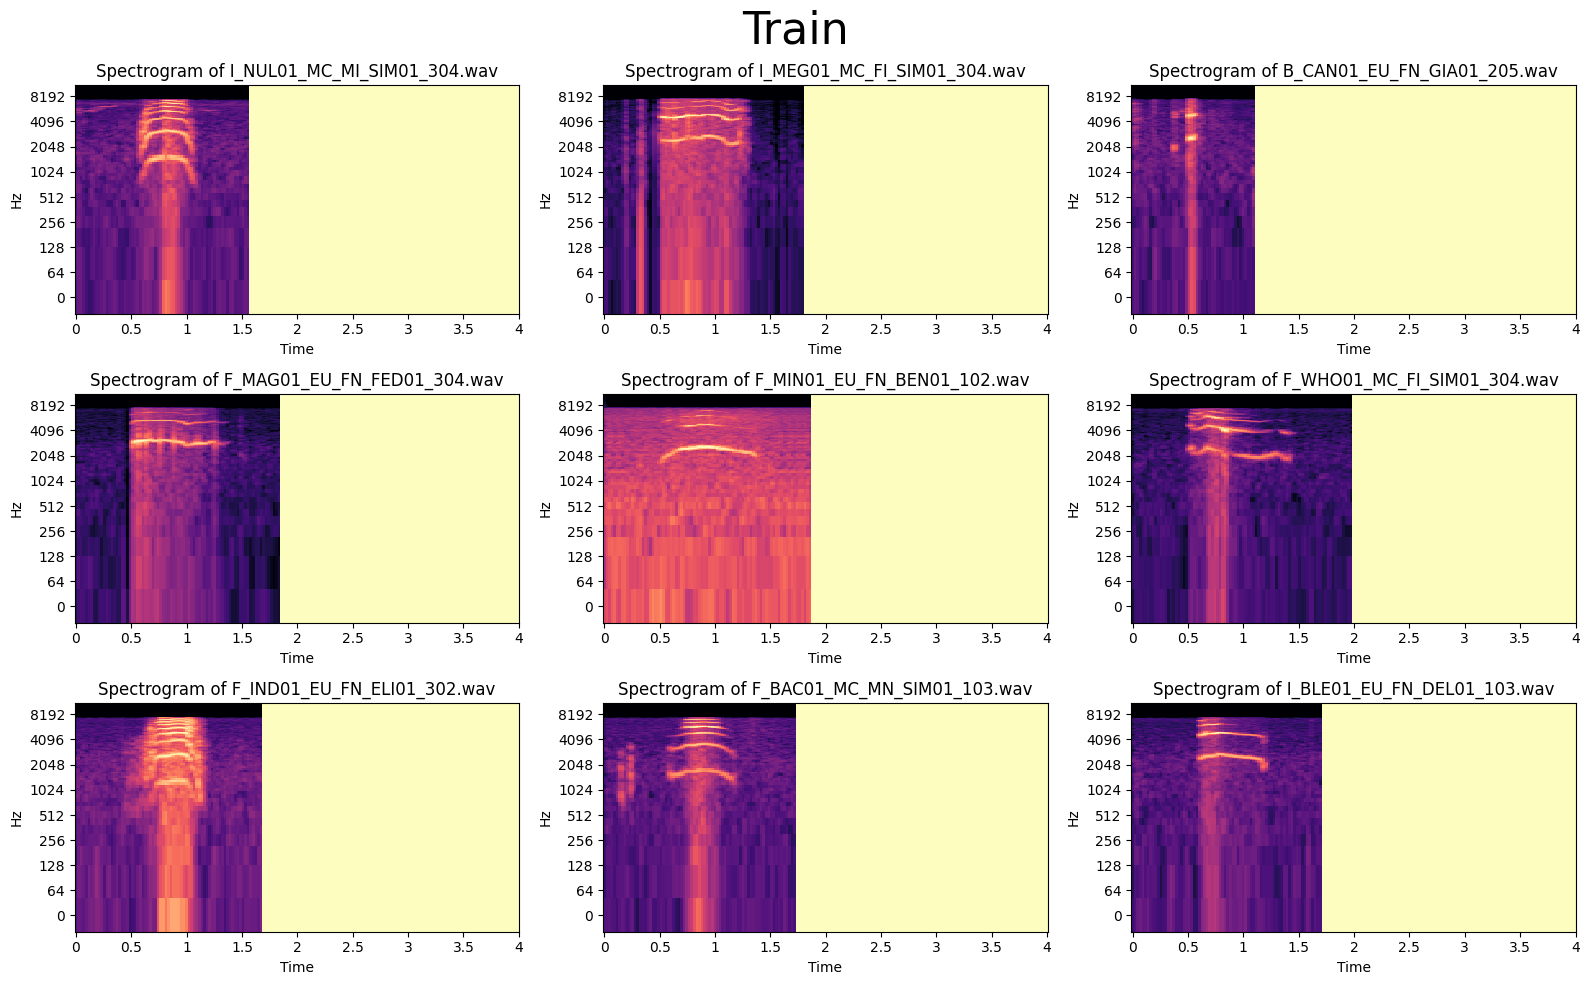

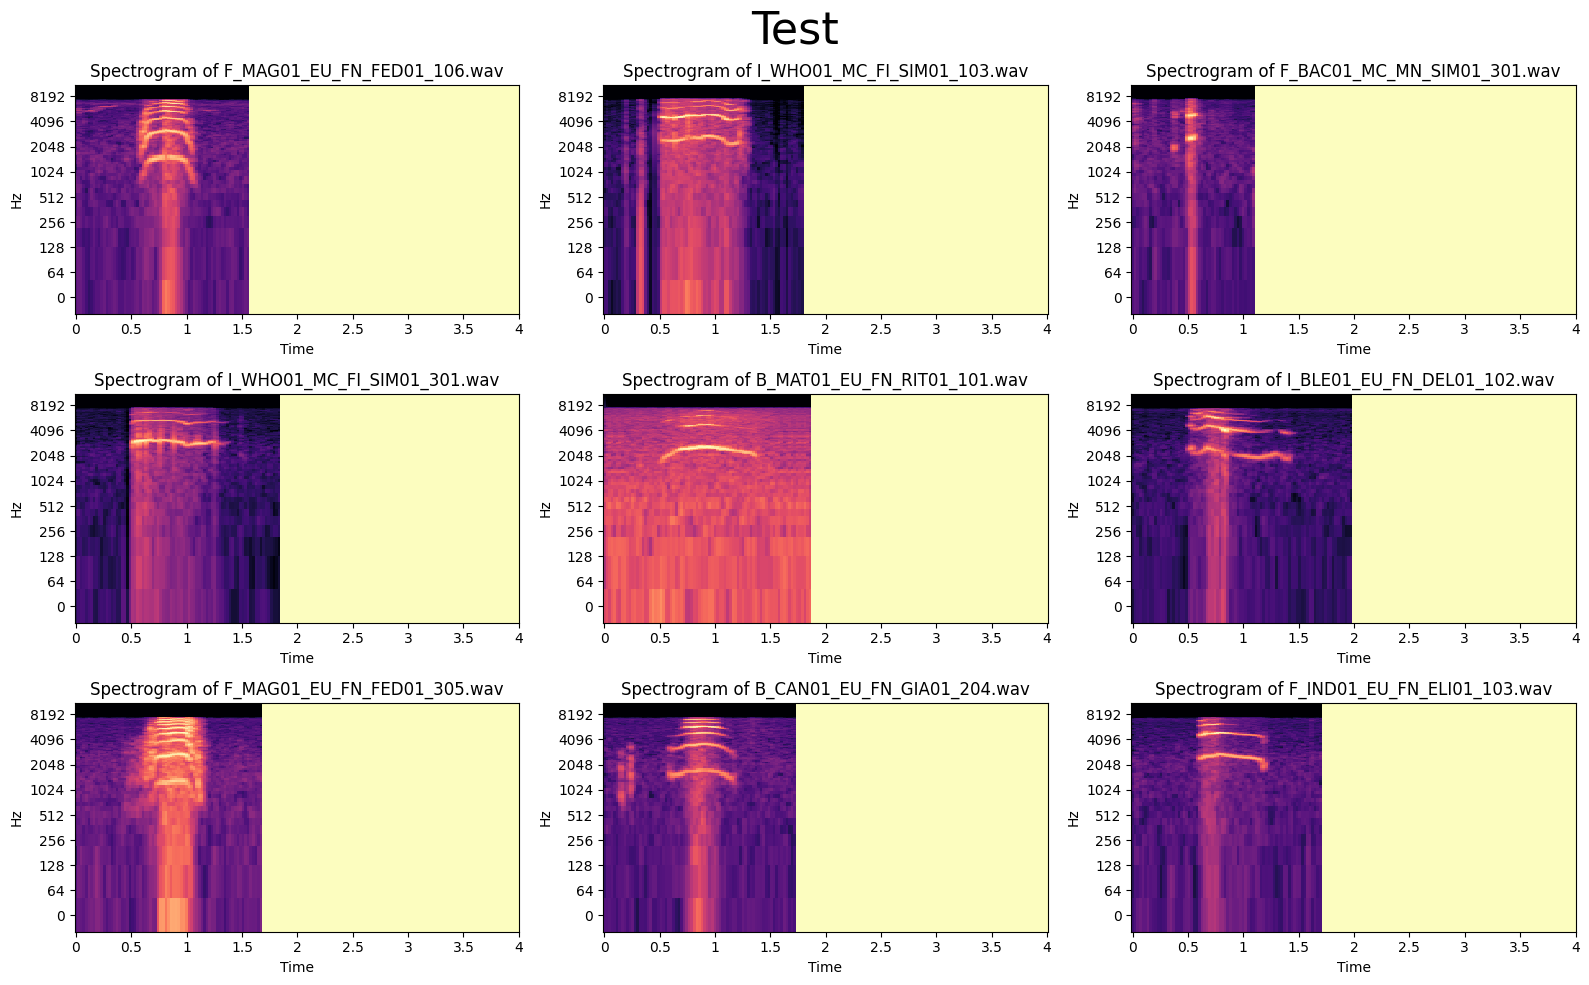

In [20]:
# plt.figure(figsize=(16, 10))

# for i in range(n):
#     # spectrogram_db, _ = wave_to_spec(rand_samples[i], train_path)
#     plt.subplot(rows, cols, i+1)
#     librosa.display.specshow(train_specs_list[i], sr=sampling_rate, x_axis='time', y_axis='log')
#     plt.title(f'Spectrogram of {os.listdir(train_path)[i]}')

# plt.tight_layout()
# plt.show()



# train
train_specs_list = []
plt.figure(figsize=(16, 10))
plt.suptitle("Train", fontsize=fontsize)

for i, spec in enumerate(test_specs_list):
    if i < n:
        plt.subplot(rows, cols, i+1)
        librosa.display.specshow(spec, sr=sampling_rate, x_axis='time', y_axis='log')
        plt.title(f'Spectrogram of {os.listdir(train_path)[i]}')

plt.tight_layout()
plt.show()

# test
plt.figure(figsize=(16, 10))
plt.suptitle("Test", fontsize=fontsize)

for i, spec in enumerate(test_specs_list):
    if i < n:
        plt.subplot(rows, cols, i+1)
        librosa.display.specshow(spec, sr=sampling_rate, x_axis='time', y_axis='log')
        plt.title(f'Spectrogram of {os.listdir(test_path)[i]}')

plt.tight_layout()
plt.show()

### 4. Prepare train labels

In [21]:
class_names = ["B", "I", "F"]
output_labels = range(len(class_names))

In [22]:
train_labels = np.array([extract_label(file, class_names, output_labels) for file in os.listdir(train_path)])
test_labels = np.array([extract_label(file, class_names, output_labels) for file in os.listdir(test_path)])

train_labels_b = tf.keras.utils.to_categorical(train_labels, num_classes=len(output_labels))
test_labels_b = tf.keras.utils.to_categorical(test_labels, num_classes=len(output_labels))

In [23]:
train_specs.shape, train_labels_b.shape

((352, 128, 173), (352, 3))

In [24]:
test_specs.shape, test_labels_b.shape

((88, 128, 173), (88, 3))

# C. Create and train the model

In [25]:
batch_size = 4
epochs = 200     # low epochs due to low amount of training data
input_shape = train_specs.shape[1:]
learning_rate = 0.001

In [26]:
input_shape

(128, 173)

In [27]:
# create the model
model = create_model()

# callbacks
def lr_schedule(epoch):
    return learning_rate * (0.1 ** (epoch // 30))


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5
)

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
model_history = model.fit(
    train_specs, 
    train_labels_b, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_split=0.15,
    callbacks=[early_stopping, lr_scheduler, reduce_lr],
    # shuffle=True
)

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3570 - loss: 1.3170 - val_accuracy: 0.3585 - val_loss: 1.2102 - learning_rate: 0.0010
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5381 - loss: 1.1210 - val_accuracy: 0.4528 - val_loss: 1.1307 - learning_rate: 0.0010
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.5037 - loss: 1.0542 - val_accuracy: 0.3396 - val_loss: 1.1526 - learning_rate: 0.0010
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5299 - loss: 1.0291 - val_accuracy: 0.3962 - val_loss: 1.0451 - learning_rate: 0.0010
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.4800 - loss: 1.0021 - val_accuracy: 0.4717 - val_loss: 1.0867 - learning_rate: 0.0010
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.6140 - loss: 0.8990 - val_accuracy: 0.5094 - val_loss: 0.9747 - learning_rate: 0.0010
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5207 - loss: 0.9368 - v

In [28]:
# ensure directory exists
weights_dir = 'model_weights'
os.makedirs(weights_dir, exist_ok=True)

In [29]:
# save model's weights
weights_path = get_next_weights_filename(weights_dir)
model.save_weights(weights_path)

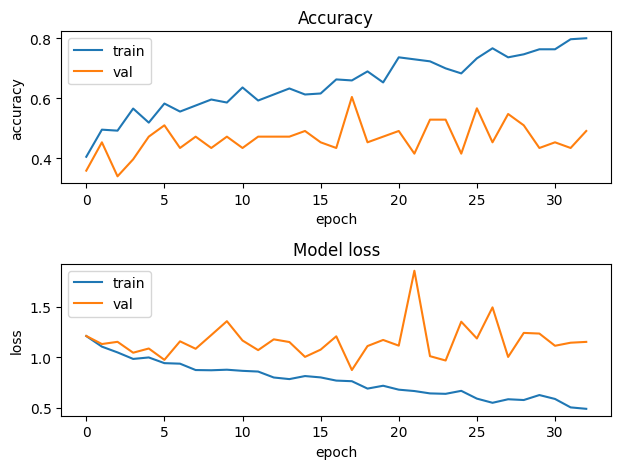

In [30]:
# check model's training history

plt.subplot(2, 1, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title(f'Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title(f'Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


plt.tight_layout()
plt.show()

In [31]:
# preview the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d-1 (Conv1D)               │ (None, 128, 4)         │           696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 128, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 4)         │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d-2 (Conv1D)               │ (None, 128, 8)         │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 128, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         8,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,987 (105.42 KB)

 Trainable params: 8,987 (35.11 KB)

 Non-trainable params: 24 (96.00 B)

 Optimizer params: 17,976 (70.22 KB)

# D. Evaluate the model

## 1. Special variables

In [32]:
class_names = ["B", "I", "F"]
output_labels = range(len(class_names))

In [33]:
test_specs.shape, test_labels_b.shape

((88, 128, 173), (88, 3))

## 2. Test the model

In [34]:
eval_input_shape = test_specs.shape[1:]
eval_input_shape

(128, 173)

In [35]:
# create the model
eval_model = create_model()

########## Choose a file with model's weights and load it
new_weights_path = os.path.join(weights_dir, select_file_from_dir(weights_dir, "0"))
eval_model.load_weights(new_weights_path)

# compile the model
eval_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# evaluate the model to get test accuracy and loss
eval_loss, eval_acc = eval_model.evaluate(test_specs, test_labels_b, batch_size=batch_size, verbose=0)

In [36]:
f"accuracy: {100 * eval_acc:5.2f}%, loss: {eval_loss:5.4f}"

'accuracy: 65.91%, loss: 0.6703'

In [37]:
# evaluate the model to get model's predictions
eval_predictions = eval_model.predict(test_specs, batch_size=batch_size)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


In [38]:
test_labels

array([2, 1, 2, 1, 0, 1, 2, 0, 2, 0, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0,
       0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 2, 1, 1, 1, 0, 0, 2, 2, 0, 1, 2, 0, 1, 2, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1])

In [39]:
eval_predictions

array([[4.06438082e-01, 3.19823176e-01, 2.73738742e-01],
       [8.68474767e-02, 8.85484457e-01, 2.76680700e-02],
       [4.72546279e-01, 5.27932160e-02, 4.74660575e-01],
       [2.61949319e-02, 9.66425896e-01, 7.37908343e-03],
       [4.91043389e-01, 3.17062959e-02, 4.77250308e-01],
       [2.92666140e-03, 9.95576024e-01, 1.49725634e-03],
       [3.06632161e-01, 4.20727402e-01, 2.72640377e-01],
       [3.19534361e-01, 4.24668700e-01, 2.55796969e-01],
       [1.59554929e-01, 7.82531619e-01, 5.79134971e-02],
       [3.91632527e-01, 3.02246064e-01, 3.06121469e-01],
       [1.65011972e-01, 7.69331872e-01, 6.56562373e-02],
       [3.07348311e-01, 3.47169638e-01, 3.45482111e-01],
       [2.41901666e-01, 5.35767555e-01, 2.22330764e-01],
       [3.09202652e-02, 9.43784595e-01, 2.52951905e-02],
       [4.70195264e-01, 5.57923168e-02, 4.74012345e-01],
       [4.56330240e-01, 1.29029766e-01, 4.14639920e-01],
       [4.94268775e-01, 5.85998781e-02, 4.47131306e-01],
       [4.90108997e-01, 7.98514

In [40]:
# check_model_predictions(eval_predictions, test_labels)

## 3. Plot waveforms of files and model's predictions

rows: 44, cols: 2, rows*cols: 88
correct_predictions: 58, incorrect_predictions: 30


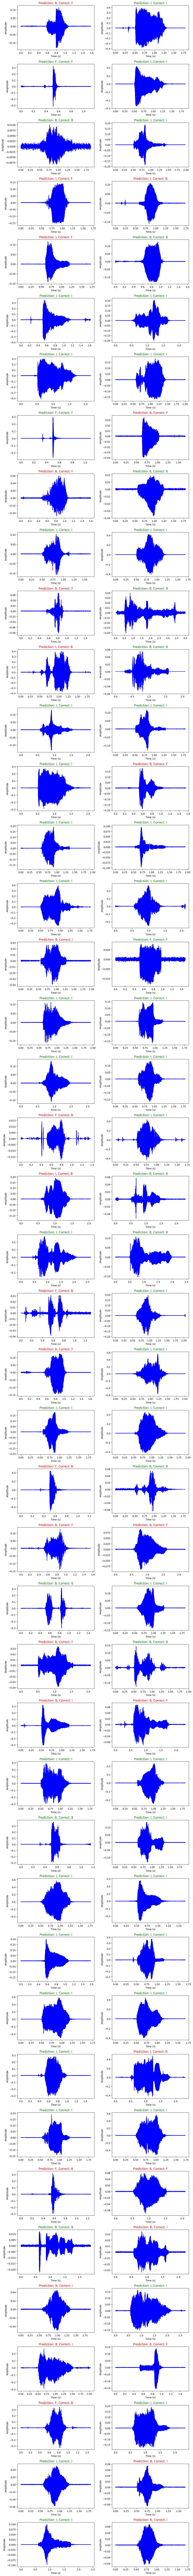

In [41]:
# Since all files are in the same order as the files in the directory, no need
# to convert them back to waveforms and try to assign labels based on their waveforms

n_1 = len(os.listdir(test_path)) # how many spectrograms will be displayed
rows_1 = int(n_1 / 2)
cols_1 = int(n_1 / rows_1)
print(f'rows: {rows_1}, cols: {cols_1}, rows*cols: {n_1}')

correct_predictions = 0

plt.figure(figsize=(11,147))
test_files = os.listdir(test_path)[:n_1]
for i in range(n_1):
    audio_data, sampling_rate, time = process_audio(test_files[i], test_path)
    plt.subplot(rows_1, cols_1, i+1)
    plt.plot(time, audio_data, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # get indices ranging from 0 to 2
    eval_prediction_indices = np.where(eval_predictions[i] == max(eval_predictions[i]))
    prediction_index = eval_prediction_indices[0].item()

    # determine the class by the indices above
    prediction_class = class_names[prediction_index]
    correct_class = class_names[test_labels[i]]

    plt.title(f'Prediction: {prediction_class}, Correct: {correct_class}', 
              color='green' if prediction_class == correct_class else 'red')

    # get the total sum of correct and incorrect predictions
    if prediction_class == correct_class:
        correct_predictions += 1

print(f"correct_predictions: {correct_predictions}, "
      f"incorrect_predictions: {eval_predictions.shape[0]-correct_predictions}")
plt.tight_layout()
plt.savefig("model_predictions.png") 
plt.show()